In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TORCHINDUCTOR_LAYOUT_OPTIMIZATION"]= "0"

In [2]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset, DatasetDict
import evaluate

import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors.torch import load_file

import math
import numpy as np

from dataclasses import dataclass

from transformers import Trainer, TrainingArguments, AutoTokenizer, DataCollatorForLanguageModeling

from huggingface_hub import notebook_login

2025-04-11 17:20:03.196179: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-11 17:20:03.211270: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744392003.230431   10933 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744392003.236235   10933 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-11 17:20:03.256829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

[2025-04-11 17:20:06,796] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [6]:
notebook_login()

In [3]:
ds = load_dataset("openwebtext")
ds

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 8013769
    })
})

In [4]:
split_dataset = ds["train"].train_test_split(test_size=0.0005, seed=69)
split_dataset['val'] = split_dataset.pop('test')

In [5]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 8009762
    })
    val: Dataset({
        features: ['text'],
        num_rows: 4007
    })
})

In [6]:
tokenizer = AutoTokenizer.from_pretrained("unsloth/Meta-Llama-3.1-8B-Instruct")

In [7]:
@dataclass
class Config:
    d_model: int = 512
    d_ff: int = 2048
    n_heads: int = 8
    vocab_size: int = len(tokenizer)

In [8]:
class PositionalEmbedding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """

        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return self.dropout(x)

class LayerAttention(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.n_heads = config.n_heads

        assert config.d_model % self.n_heads == 0, "d_model should be divisible by n_heads"

        self.d_k = config.d_model // self.n_heads

        self.w_q = nn.Linear(config.d_model, config.d_model)
        self.w_k = nn.Linear(config.d_model, config.d_model)
        self.w_v = nn.Linear(config.d_model, config.d_model)
        self.w_o = nn.Linear(config.d_model, config.d_model)

    def forward(self, query, key, value, attention_mask=None, return_attn=False):
        bs, seq_len = query.size(0), query.size(1)
        
        # Q, K, V
        q = self.w_q(query)
        k = self.w_k(key)
        v = self.w_v(value)
    
        q = q.view(bs, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(bs, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(bs, seq_len, self.n_heads, self.d_k).transpose(1, 2)
    
        # QK^T
        qk = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
    
        # === MASKING ===
        causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=query.device)).bool()
        causal_mask = ~causal_mask  # True = запрет
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, seq_len]
    
        if attention_mask is not None:
            pad_mask = attention_mask.unsqueeze(1).unsqueeze(2) == 0  # [batch, 1, 1, seq_len]
            full_mask = pad_mask | causal_mask
        else:
            full_mask = causal_mask
    
        qk = qk.masked_fill_(full_mask, torch.finfo(qk.dtype).min)
    
        # === ATTENTION ===
        attn_scores = qk.softmax(-1)
        attn_values = attn_scores @ v
        output = attn_values.transpose(1, 2).reshape(bs, seq_len, -1)
        output = self.w_o(output)
    
        if return_attn:
            return output, attn_scores
        return output


class AtAtModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.d_model)
        self.attn1 = LayerAttention(config)
        self.attn2 = LayerAttention(config)
        self.unembed = nn.Linear(config.d_model, config.vocab_size)
        self.criterion = nn.CrossEntropyLoss()
        self.pe = PositionalEmbedding(config.d_model)

    def forward(self, input_ids, labels, attention_mask=None):
        x = self.embed(input_ids)  # [bs, seq, d_model]
        x = self.pe(x)
        x = x + self.attn1(x, x, x, attention_mask)
        x = x + self.attn2(x, x, x, attention_mask)
        logits = self.unembed(x).transpose(1, 2)  # [bs, vocab, seq]
        shift_logits = logits[..., :-1].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss = self.criterion(shift_logits, shift_labels)
        return {'loss': loss, 'logits': logits}

# class AtAtModel(nn.Module):
#     def __init__(self, config: Config):
#         super().__init__()
#         self.embed = nn.Embedding(config.vocab_size, config.d_model)
#         self.attn1 = nn.MultiheadAttention(config.d_model, config.n_heads, batch_first=True)
#         self.attn2 = nn.MultiheadAttention(config.d_model, config.n_heads, batch_first=True)
#         self.unembed = nn.Linear(config.d_model, config.vocab_size)
#         self.criterion = nn.CrossEntropyLoss()

#     def forward(self, input_ids, labels, attention_mask=None):
#         x = self.embed(input_ids)  # [bs, seq, d_model]
#         causal_mask = torch.triu(torch.ones(x.shape[1], x.shape[1]), diagonal=1).bool().to(x.device)
#         attn_output, _ = self.attn1(x, x, x, attn_mask=causal_mask, is_causal=True)
#         x = x + attn_output
#         attn_output, _ = self.attn2(x, x, x, attn_mask=causal_mask, is_causal=True)
#         x = x + attn_output
#         logits = self.unembed(x).transpose(1, 2)  # [bs, vocab, seq]
#         loss = self.criterion(logits, labels)
#         return {'loss': loss, 'logits': logits}



class CoAtModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.d_model)
        self.conv = nn.Conv1d(
            in_channels=config.d_model,
            out_channels=config.d_model,
            kernel_size=3,
            bias=False
        )
        self.attn = LayerAttention(config)
        self.unembed = nn.Linear(config.d_model, config.vocab_size)
        self.criterion = nn.CrossEntropyLoss()
        self.pe = PositionalEmbedding(config.d_model)

    def forward(self, input_ids, labels, attention_mask=None):
        x = self.embed(input_ids)          # [bs, seq, d_model]
        x = self.pe(x)
        x = x.transpose(1, 2)              # [bs, d_model, seq]
        x = F.pad(x, (2, 0))               # causal padding for kernel=3
        x = self.conv(x)                   # [bs, d_model, seq]
        x = x.transpose(1, 2)              # [bs, seq, d_model]

        x = x + self.attn(x, x, x, attention_mask)
        x = x.contiguous()
        logits = self.unembed(x).transpose(1, 2)
        shift_logits = logits[..., :-1].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss = self.criterion(shift_logits, shift_labels)
        return {'loss': loss, 'logits': logits}



config = Config()

atat_model = AtAtModel(config)
coat_model = CoAtModel(config)

In [9]:
context_length = 128

def tokenize(element):
    outputs = tokenizer(
        element["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}

tokenized_datasets = split_dataset.map(
    tokenize, batched=True, remove_columns=ds['train'].column_names
)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 63148382
    })
    val: Dataset({
        features: ['input_ids'],
        num_rows: 31066
    })
})

In [10]:
from datasets import DatasetDict

shuffled_train = tokenized_datasets["train"].shuffle(seed=69)
shuffled_val = tokenized_datasets["val"].shuffle(seed=69)

# subset_train = shuffled_train.select(range(50_000))
# subset_val = shuffled_val.select(range(5000))
# subset_train = shuffled_train
# subset_val = shuffled_val

tokenized_datasets = DatasetDict({
    "train": shuffled_train,
    "val": shuffled_val
})
tokenized_datasets


DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 63148382
    })
    val: Dataset({
        features: ['input_ids'],
        num_rows: 31066
    })
})

In [11]:
# def count_tokens(batch):
#     return {"num_tokens": [len(ids) for ids in batch["input_ids"]]}

# with_token_counts = tokenized_datasets["train"].map(count_tokens, batched=True)
# total = sum(with_token_counts["num_tokens"])
# print(f"Total tokens in train: {total}")


In [12]:
# total_tokens = sum(len(example["input_ids"]) for example in tokenized_datasets["train"])
# print(f"Total tokens in train dataset: {total_tokens}")


In [13]:
tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [14]:
out = data_collator([tokenized_datasets['train'][i] for i in range(5)])
for key in out:
    print(f"{key} shape: {out[key].shape}")

input_ids shape: torch.Size([5, 128])
attention_mask shape: torch.Size([5, 128])
labels shape: torch.Size([5, 128])


In [15]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(
        predictions=predictions.flatten(),
        references=labels.flatten()
    )


In [16]:
args = TrainingArguments(
    output_dir="co-at-pretrain-v3",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    eval_strategy="steps",
    eval_steps=10000,
    # eval_accumulation_steps=8,
    logging_steps=10000,
    # gradient_accumulation_steps=8,
    num_train_epochs=1,
    weight_decay=0.1,
    warmup_steps=1000,
    lr_scheduler_type="cosine",
    learning_rate=5e-4,
    save_steps=50000,
    fp16=True,
    report_to="tensorboard",
    save_total_limit=3,
    torch_compile=True,
    torch_compile_backend="inductor"
)

trainer = Trainer(
    model=coat_model,
    processing_class=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    # compute_metrics=compute_metrics
)

[2025-04-11 06:29:28,173] [INFO] [real_accelerator.py:219:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [17]:
trainer.train(resume_from_checkpoint="co-at-pretrain-v3/checkpoint-200000/")

Step,Training Loss,Validation Loss
210000,4.766100,4.682082
220000,4.761700,4.673711
230000,4.756700,4.674236
240000,4.751600,4.668578
250000,4.746200,4.663543
260000,4.740700,4.656866
270000,4.736100,4.647852
280000,4.730400,4.641923
290000,4.725200,4.643666
300000,4.719600,4.631516


TorchRuntimeError: Failed running call_module L__args___0_criterion(*(FakeTensor(..., device='cuda:0', size=(s0, 128256, 127), dtype=torch.float16,
           grad_fn=<CloneBackward0>), FakeTensor(..., device='cuda:0', size=(s0, 127), dtype=torch.int64)), **{}):
Cannot call numel() on tensor with symbolic sizes/strides
Exception raised from throw_cannot_call_with_symbolic at ../c10/core/TensorImpl.cpp:298 (most recent call first):
frame #0: c10::Error::Error(c10::SourceLocation, std::string) + 0x57 (0x7fa3d0381d87 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #1: c10::TensorImpl::throw_cannot_call_with_symbolic(char const*) const + 0x9c (0x7fa3d0330e40 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #2: <unknown function> + 0x5b96f (0x7fa3d035d96f in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libc10.so)
frame #3: at::native::nll_loss_nd_symint(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, long, c10::SymInt) + 0xfd6 (0x7fa3b8b0fc56 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #4: <unknown function> + 0x2ee83c2 (0x7fa3b9ce83c2 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #5: <unknown function> + 0x2f31a69 (0x7fa3b9d31a69 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #6: <unknown function> + 0x75d1df (0x7fa3ceb5d1df in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #7: <unknown function> + 0x1a060b7 (0x7fa3b88060b7 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #8: <unknown function> + 0x1a065a7 (0x7fa3b88065a7 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #9: <unknown function> + 0x75d1df (0x7fa3ceb5d1df in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #10: <unknown function> + 0x1a060b7 (0x7fa3b88060b7 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #11: <unknown function> + 0x268ea5d (0x7fa3b948ea5d in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #12: at::_ops::nll_loss_nd::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, long, c10::SymInt) + 0x5fb (0x7fa3b9449aeb in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #13: at::native::cross_entropy_loss_symint(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, long, c10::SymInt, double) + 0x6ba (0x7fa3b8b0b71a in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #14: <unknown function> + 0x2ee8b82 (0x7fa3b9ce8b82 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #15: <unknown function> + 0x2f2d2c4 (0x7fa3b9d2d2c4 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #16: <unknown function> + 0x75d1df (0x7fa3ceb5d1df in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #17: <unknown function> + 0x1a060b7 (0x7fa3b88060b7 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #18: <unknown function> + 0x1a065a7 (0x7fa3b88065a7 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #19: <unknown function> + 0x75d1df (0x7fa3ceb5d1df in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #20: <unknown function> + 0x1a060b7 (0x7fa3b88060b7 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #21: <unknown function> + 0x29a3a3e (0x7fa3b97a3a3e in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #22: at::_ops::cross_entropy_loss::call(at::Tensor const&, at::Tensor const&, std::optional<at::Tensor> const&, long, c10::SymInt, double) + 0x623 (0x7fa3b975fee3 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_cpu.so)
frame #23: <unknown function> + 0x6b772b (0x7fa3ceab772b in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #24: <unknown function> + 0x18ae12 (0x55b467b8ae12 in /usr/bin/python3)
frame #25: _PyObject_MakeTpCall + 0x25b (0x55b467b8175b in /usr/bin/python3)
frame #26: _PyEval_EvalFrameDefault + 0x5f66 (0x55b467b7b1d6 in /usr/bin/python3)
frame #27: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #28: _PyFunction_Vectorcall + 0x7c (0x55b467b8b66c in /usr/bin/python3)
frame #29: _PyEval_EvalFrameDefault + 0x18d3 (0x55b467b76b43 in /usr/bin/python3)
frame #30: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #31: <unknown function> + 0x1988de (0x55b467b988de in /usr/bin/python3)
frame #32: _PyEval_EvalFrameDefault + 0x2a83 (0x55b467b77cf3 in /usr/bin/python3)
frame #33: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #34: <unknown function> + 0x1988de (0x55b467b988de in /usr/bin/python3)
frame #35: _PyEval_EvalFrameDefault + 0x2a83 (0x55b467b77cf3 in /usr/bin/python3)
frame #36: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #37: _PyObject_FastCallDictTstate + 0xc4 (0x55b467b80934 in /usr/bin/python3)
frame #38: _PyObject_Call_Prepend + 0x5c (0x55b467b958ec in /usr/bin/python3)
frame #39: <unknown function> + 0x29cba4 (0x55b467c9cba4 in /usr/bin/python3)
frame #40: PyObject_Call + 0xbb (0x55b467b993cb in /usr/bin/python3)
frame #41: _PyEval_EvalFrameDefault + 0x2a83 (0x55b467b77cf3 in /usr/bin/python3)
frame #42: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #43: _PyFunction_Vectorcall + 0x7c (0x55b467b8b66c in /usr/bin/python3)
frame #44: _PyEval_EvalFrameDefault + 0x6bf (0x55b467b7592f in /usr/bin/python3)
frame #45: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #46: _PyFunction_Vectorcall + 0x7c (0x55b467b8b66c in /usr/bin/python3)
frame #47: _PyEval_EvalFrameDefault + 0x6bf (0x55b467b7592f in /usr/bin/python3)
frame #48: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #49: _PyFunction_Vectorcall + 0x7c (0x55b467b8b66c in /usr/bin/python3)
frame #50: _PyEval_EvalFrameDefault + 0x6bf (0x55b467b7592f in /usr/bin/python3)
frame #51: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #52: _PyFunction_Vectorcall + 0x7c (0x55b467b8b66c in /usr/bin/python3)
frame #53: _PyEval_EvalFrameDefault + 0x18d3 (0x55b467b76b43 in /usr/bin/python3)
frame #54: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #55: _PyFunction_Vectorcall + 0x7c (0x55b467b8b66c in /usr/bin/python3)
frame #56: PyObject_Call + 0x122 (0x55b467b99432 in /usr/bin/python3)
frame #57: _PyEval_EvalFrameDefault + 0x2a83 (0x55b467b77cf3 in /usr/bin/python3)
frame #58: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #59: _PyFunction_Vectorcall + 0x7c (0x55b467b8b66c in /usr/bin/python3)
frame #60: _PyEval_EvalFrameDefault + 0x18d3 (0x55b467b76b43 in /usr/bin/python3)
frame #61: <unknown function> + 0x81f784 (0x7fa3cec1f784 in /home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/lib/libtorch_python.so)
frame #62: _PyFunction_Vectorcall + 0x7c (0x55b467b8b66c in /usr/bin/python3)
frame #63: _PyEval_EvalFrameDefault + 0x804 (0x55b467b75a74 in /usr/bin/python3)


from user code:
   File "/home/podsevatkin.n/.local/lib/python3.10/site-packages/accelerate/utils/operations.py", line 820, in forward
    return model_forward(*args, **kwargs)
  File "/home/podsevatkin.n/.local/lib/python3.10/site-packages/accelerate/utils/operations.py", line 808, in __call__
    return convert_to_fp32(self.model_forward(*args, **kwargs))
  File "/home/podsevatkin.n/.local/lib/python3.10/site-packages/torch/amp/autocast_mode.py", line 16, in decorate_autocast
    return func(*args, **kwargs)
  File "/tmp/ipykernel_3705/2472453003.py", line 148, in forward
    loss = self.criterion(shift_logits, shift_labels)

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True


In [9]:
state_dict = load_file("co-at-pretrain-v3/checkpoint-450000/model.safetensors")
coat_model.load_state_dict(state_dict)

<All keys matched successfully>

In [16]:
state_dict = load_file("at-at-pretrain/checkpoint-585/model.safetensors")
atat_model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
text = """Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.

Mr Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbours."""



text_bigger = """Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.

Mr Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbours.The Dursleys had a small son called Dudley and in their opinion there was no finer boy anywhere.

The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn’t think they could bear it if anyone found out about the Potters. Mrs Potter was Mrs Dursley’s sister, but they hadn’t met for several years; in fact, Mrs Dursley pretended she didn’t have a sister, because her sister and her good-for-nothing husband were as unDursleyish as it was possible to be. The Dursleys shuddered to think what the neighbours would say if the Potters arrived in the street. The Dursleys knew that the Potters had a small son, too, but they had never even seen him. This boy was another good reason for keeping the Potters away; they didn’t want Dudley mixing with a child like that."""

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [15]:
coat_model.to(device)

CoAtModel(
  (embed): Embedding(128256, 512)
  (conv): Conv1d(512, 512, kernel_size=(3,), stride=(1,), bias=False)
  (attn): LayerAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (w_o): Linear(in_features=512, out_features=512, bias=True)
  )
  (unembed): Linear(in_features=512, out_features=128256, bias=True)
  (criterion): CrossEntropyLoss()
  (pe): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [16]:
tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
input_ids = tokens.input_ids.to(device)
attention_mask = tokens.attention_mask.to(device)

In [17]:
def get_attn_scores(model):
    with torch.no_grad():
        x = model.embed(input_ids)
        x = x.transpose(1, 2)
        x = F.pad(x, (2, 0))
        x = model.conv(x)
        x = x.transpose(1, 2)
    
        x, attn_scores = model.attn(x, x, x, return_attn=True)
    return x, attn_scores

In [18]:
x, attn_scores = get_attn_scores(coat_model)

In [19]:
tokens_str = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens_str[:10]

['<|begin_of_text|>',
 'Mr',
 'Ġand',
 'ĠMrs',
 'ĠD',
 'urs',
 'ley',
 ',',
 'Ġof',
 'Ġnumber']

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_attention_map(attn_matrix, tokens, head=0):
    """
    attn_matrix: [n_heads, seq_len, seq_len]
    tokens: список токенов
    """
    attn = attn_matrix[head].detach().cpu().numpy()
    seq_len = len(tokens)
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn[:seq_len, :seq_len], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Attention Map - Head {head}")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


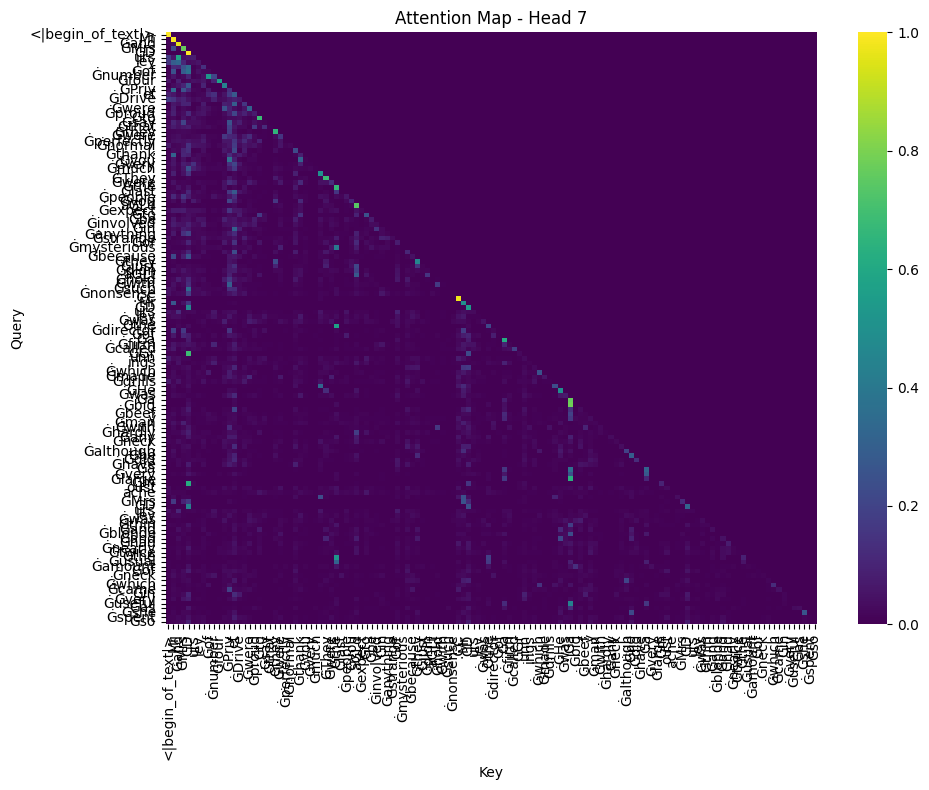

In [21]:
plot_attention_map(attn_scores[0], tokens_str, head=7)


In [25]:
from circuitsvis.attention import attention_patterns

In [26]:
attn_scores = attn_scores[0]  # берем 1-й пример
attn_scores = attn_scores.detach().cpu()

# Приводим к [num_layers, num_heads, seq_len, seq_len]
# В твоем случае возможно только 1 слой → нужно добавить ось
attn_tensor = attn_scores.unsqueeze(0)  # shape: [1, n_heads, seq_len, seq_len]

# Токены
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

In [27]:
len(tokens)

128

In [28]:
tokenizer.decode(input_ids[0])

'<|begin_of_text|>Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.\n\nMr Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so'

In [29]:
attn_tensor = attn_tensor.squeeze(0)
attn_tensor.shape

torch.Size([128, 128])

In [30]:
tokens = [token.replace("Ġ", " ") for token in tokens]
tokens[:10]

['<|begin_of_text|>',
 'Mr',
 ' and',
 ' Mrs',
 ' D',
 'urs',
 'ley',
 ',',
 ' of',
 ' number']

In [32]:
attention_patterns(
    tokens=tokens,
    attention=attn_tensor
)
